In [1]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()
coloc = spark.read.parquet(
    "gs://genetics-portal-dev-data/22.09.1/outputs/v2d_coloc"
).filter(F.col("right_type") != "gwas")

In [15]:
ot_genetics = spark.read.parquet(
    "gs://open-targets-data-releases/23.06/output/etl/parquet/evidence/sourceId=ot_genetics_portal")

In [19]:
evidences=spark.read.parquet("gs://open-targets-data-releases/23.06/output/etl/parquet/evidence/")

In [59]:
#### run direction of effect over evidences: 
### 31.07.2023
### cleaned on 15.08.2023

#### RELEASE 23.06


## https://stackoverflow.com/questions/45629781/drop-if-all-entries-in-a-spark-dataframes-specific-column-is-null
## drop columns with all values = Null

def drop_fully_null_columns(df, but_keep_these=[]):
    """Drops DataFrame columns that are fully null
    (i.e. the maximum value is null)

    Arguments:
        df {spark DataFrame} -- spark dataframe
        but_keep_these {list} -- list of columns to keep without checking for nulls

    Returns:
        spark DataFrame -- dataframe with fully null columns removed
    """

    # skip checking some columns
    cols_to_check = [col for col in df.columns if col not in but_keep_these]
    if len(cols_to_check) > 0:
        # drop columns for which the max is None
        rows_with_data = df.select(*cols_to_check).groupby().agg(*[F.max(c).alias(c) for c in cols_to_check]).take(1)[0]
        cols_to_drop = [c for c, const in rows_with_data.asDict().items() if const == None]
        new_df = df.drop(*cols_to_drop)

        return new_df
    else:
        return df
    
#1# Make a list of variant of interest (Sequence ontology terms) to subset data of interest. 

### Bear in mind that SO works with ontology structure as: SO:XXXXXX, but databases has the SO as: SO_XXXXXX

var_filter_lof = [
    ### High impact variants https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html
    "SO_0001589",## frameshit_variant
    "SO_0001587",## stop_gained
    "SO_0001574",## splice_acceptor_variant
    "SO_0001575",## splice_donor_variant
    "SO_0002012",## start_lost
    "SO_0001578",## stop_lost
    "SO_0001893",## transcript_ablation
    # "SO:0001889", ## transcript_amplification ## the Only HIGH impact that increase protein.
]

gof=['SO_0002053']
lof=['SO_0002054']


## Building Sequence Ontology 
so_path="gs://ot-team/jroldan/sequenceOntology_20221118.csv"
so_ontology=spark.read.csv(so_path, header=True)
building=(so_ontology
.select(F.col('Accession'), F.col('Parents'))
.withColumn('Parentalind',
    F.split(F.col('Parents'), ","))
.withColumn('Parentalind', F.explode_outer('Parentalind'))
.groupBy('Parentalind')
.agg(F.collect_list(F.col('Accession')).alias('childrens'))
.join(so_ontology, F.col('Parentalind')==so_ontology.Accession, 'right')
)

## others
target_path="gs://open-targets-data-releases/23.06/output/etl/parquet/targets/"
target=spark.read.parquet(target_path)
disease_path="gs://open-targets-data-releases/23.06/output/etl/parquet/diseases/"
diseases=spark.read.parquet(disease_path)
dis_name=diseases.select('id','name')
indication_path="gs://open-targets-data-releases/23.06/output/etl/parquet/indication/"
indication=spark.read.parquet(indication_path)
mecact_path="gs://open-targets-data-releases/23.06/output/etl/parquet/mechanismOfAction/"
mecact=spark.read.parquet(mecact_path)

#### GENE BURDEN

### We manually annotated those studies using LoF or PTV variants

burden_lof_path="gs://ot-team/jroldan/20230704_geneBurden_StudyInclusion.csv"
burden_lof=spark.read.csv(burden_lof_path, header=True)
burden_lof=burden_lof.withColumnRenamed('statisticalMethodOverview','stMethod')

## annotate TSG/oncogene/bivalent using 'hallmarks.attributes'

oncotsg_list = ['TSG','oncogene','Oncogene','oncogene','oncogene,TSG','TSG,oncogene','fusion,oncogene','oncogene,fusion']

oncolabel=(target
.select('id','approvedSymbol',F.explode_outer(F.col('hallmarks.attributes')))
.select('id','approvedSymbol','col.description')
.filter(F.col('description').isin(oncotsg_list))
.groupBy('id','approvedSymbol')
.agg(F.collect_set('description').alias('description'))
.withColumn('description_splited',
    F.concat_ws(",", F.col('description')))
.withColumn('TSorOncogene', 
    F.when(
        (F.col('description_splited').rlike('ncogene') &
        F.col('description_splited').rlike('TSG'))
        , F.lit('bivalent'))
    .when(
        F.col('description_splited').rlike('ncogene(\s|$)')
        , F.lit('oncogene'))
    .when(
        F.col('description_splited').rlike('TSG(\s|$)')
        , F.lit('TSG'))       
    .otherwise(F.lit('noEvaluable')))
.withColumnRenamed('id','target_id')

)

#### rlike('('+Keywords+')(\s|$)'

### on 03.07.2023 we add the categories: 
# DISRUPTING AGENT - inhibitor 
# STABILISER - activator

### Hacer el join del actionType con el chembl para sacar los mecanismos de accion. 
inhibitors = [
'RNAI INHIBITOR',
'NEGATIVE MODULATOR',
'NEGATIVE ALLOSTERIC MODULATOR',
'ANTAGONIST',
'ANTISENSE INHIBITOR',
'BLOCKER',
'INHIBITOR',
'DEGRADER',
'INVERSE AGONIST',
'ALLOSTERIC ANTAGONIST', 
'DISRUPTING AGENT' ## added new on 03.07.2023
] 

activators=[
'PARTIAL AGONIST',
'ACTIVATOR',
'POSITIVE ALLOSTERIC MODULATOR',
'POSITIVE MODULATOR',
'AGONIST',
'SEQUESTERING AGENT', 
'STABILISER'## added new on 03.07.2023
] 

columnas= ['activator','inhibitor']
both=activators+inhibitors

actiontype2=(mecact
.select('chemblIds','actionType','mechanismOfAction','targets')
.select(F.explode_outer('chemblIds').alias('drugId2'),'actionType','mechanismOfAction','targets')
.select(F.explode_outer('targets').alias('targetId2'), 'drugId2','actionType','mechanismOfAction')
.dropDuplicates())


chembl1=chembl.select('targetId','drugId','diseaseId','clinicalPhase','diseaseFromSourceId')
chembl2=(chembl1
.join(actiontype2,
    (actiontype2.drugId2==F.col('drugId')) & 
    (actiontype2.targetId2==F.col('targetId')),
 'left')
.drop('targetId2','drugId2')
###.dropDuplicates()
.withColumn('twoCategories_new',
    F.when(F.col('actionType').isin(inhibitors), F.lit('inhibitor'))
    .when(F.col('actionType').isin(activators), F.lit('activator'))
    .otherwise(F.lit('noEvaluable'))))

chembl3=(chembl2
.filter(F.col('twoCategories_new')!='noEvaluable')
.groupBy('targetId','diseaseId')
.pivot('twoCategories_new')
.agg(F.count('targetId')))

chembl4=(chembl3
.select(
    'targetId',
    'diseaseId',
    ##'clinicalPhase',
    *(F.col(c).cast("int").alias(c) for c in columnas))
.withColumn('coherency',
    F.when(
        (
        (F.col('activator').isNotNull()) &
        (F.col('inhibitor').isNotNull())
        ),
            F.when(
                (F.col('activator'))-(F.col('inhibitor'))!=(F.col('activator'))
                ,F.lit('dispar'))
    )
))

# Define a conditional column to represent the subset where datasourceId is "intogen"
condition_col = F.when(F.col("datasourceId") == "intogen", 1).otherwise(0)
# Define the Window specification partitioned by "targetId" and "diseaseId" and ordered by the condition column
window_spec = Window.partitionBy("targetId", "diseaseId").orderBy(condition_col.desc())

### Join all datasets

#dfs=[otgenetics,gene_burden,eva_germline,eva_somatic,g2p,orphanet,cgc,intogen,impc,chembl]


#all = dfs[0]
#for df in dfs[1:]:
#    all = all.unionByName(df, allowMissingColumns=True)
#all.count()

all=evidences

#### 20230203 ### 
prueba_assessment=(all
.withColumn("beta",F.col("beta").cast('float')) ## for ot genetics & gene burden
.withColumn("OddsRatio",F.col("OddsRatio").cast('float')) ## for ot genetics & gene burden
.withColumn('clinicalSignificances',F.concat_ws(",",F.col("clinicalSignificances"))) ### for eva
.withColumn("mutatedSamplesVariantInfo", F.coalesce(F.col('mutatedSamples.functionalConsequenceId'), F.array()))### for intogen
# Define a conditional column to represent the subset where datasourceId is "intogen"
.withColumn("nullColumn", F.array(F.lit(None)))
.withColumn(
    "intogenAnnot",
    # F.when(F.col("datasourceId")=="intogen",
    F.size(
        F.flatten(
            F.collect_set(
                    F.array_except(
                        F.col("mutatedSamples.functionalConsequenceId"), F.col("nullColumn"))
            ).over(window_spec)
        )
    ))
.join(oncolabel, 
oncolabel.target_id==F.col('targetId'), 'left')### para cgc 
.join(burden_lof, 
burden_lof.stMethod == F.col('statisticalMethodOverview'), 'left') ### para gene burden
.join(actiontype2, ## para chembl
    (actiontype2.drugId2==F.col('drugId')) & 
    (actiontype2.targetId2==F.col('targetId')),
 'left')
.withColumn('Assessment',
#### Ot_genetics Portal ### updated to include the coloc+gwas analysis 
        F.when(F.col('datasourceId')=='ot_genetics_portal',

               # F.when(  ### label 14 evidences that are contradictory
                #        (                       
                #        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                #        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) 
                #        )
                #        ,
                #        F.lit('dispar'))
                ### evidences with gwas+coloc increased expression without + var_lof
                F.when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('GoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('GoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('beta') <0), F.lit('GoF_protect'))
                                .when((F.col('beta') >0), F.lit('GoF_risk'))
                        ) 

                ### evidences with coherent Gwas-coloc + var_lof
                .when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                ### evidences with colo+Gwas data but not variants
                .when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                ### evidences with coherent non/inconclusive gwas+coloc + var_lof
                .when(  
                        (
                        (F.col('beta').isNull()) &
                                (
                                (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002314') |
                                (F.col('variantFunctionalConsequenceFromQtlId').isNull())
                                ) &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(  
                        (
                        (F.col('oddsRatio').isNull()) &
                                (
                                (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002314') |
                                (F.col('variantFunctionalConsequenceFromQtlId').isNull())
                                ) &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                
                .otherwise(F.lit('noEvaluable')))  ### son tambien no data las que tiene riesgo pero no tienen LoF

#### Gene burden                            
        .when(F.col('datasourceId')=='gene_burden',
        ### .filter(F.col('variantType').isin(var_filter))
                F.when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('beta').isNull()) &  
                        (F.col('OddsRatio') > 1)
                        ), 
                        F.lit('LoF_risk')
                        )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('beta').isNull()) & 
                        (F.col('OddsRatio') <1) 
                        ),
                        F.lit('LoF_protect')
                )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('OddsRatio').isNull()) & 
                        (F.col('beta') >0)
                        ), 
                        F.lit('LoF_risk')
                )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('OddsRatio').isNull()) & 
                        (F.col('beta') <0) 
                        ),
                        F.lit('LoF_protect')
                )
                .otherwise(F.lit('noEvaluable')) ### son tambien no data las que tiene riesgo pero no se ensayan LoF o PT 
                        )
    #### Eva_germline                        
        .when(F.col('datasourceId')=='eva',              
                F.when(
                        (
                        ## (F.col('clinicalSignificances')!='likely pathogenic') &  
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) &
                        F.col('clinicalSignificances').rlike('(pathogenic)$')
                        ),
                        F.lit('LoF_risk'))
                .when(
                        (
                        F.col('clinicalSignificances').contains('protective')&  
                        F.col('variantFunctionalConsequenceId').isin(var_filter_lof)),
                        F.lit('LoF_protect'))
                .otherwise(F.lit('noEvaluable')) ### Son todas aquellas que tenen info pero no son patogenicas/protective  + LoF
                        )
    #### Eva_somatic  
        .when(F.col('datasourceId')=='eva_somatic',              
                F.when(
                        (
                        ##(F.col('clinicalSignificances')!='likely pathogenic') &  
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) &
                        F.col('clinicalSignificances').rlike('(pathogenic)$')
                        ),
                        F.lit('LoF_risk'))
                .when(
                        (
                        F.col('clinicalSignificances').contains('protective')&  
                        F.col('variantFunctionalConsequenceId').isin(var_filter_lof)),
                        F.lit('LoF_protect'))
                .otherwise(F.lit('noEvaluable')) ### Son todas aquellas que tenen info pero no son patogenicas/protective  + LoF
                        )
#### G2P                     
        .when(F.col('datasourceId')=='gene2phenotype',  
                F.when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002317', F.lit('LoF_risk')
                        ) ### absent gene product
                .when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002315', F.lit('GoF_risk')
                        ) ### increased gene product level
                .otherwise(F.lit('noEvaluable')))
#### Orphanet 
        .when(F.col('datasourceId')=='orphanet',  
                F.when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002054', F.lit('LoF_risk')
                        ) ### Loss_of_Function Variant
                .when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002053', F.lit('GoF_risk')
                        ) ### Gain_of_Function Variant
                .otherwise(F.lit('noEvaluable')))
 #### CGC               
        .when(F.col('datasourceId')=='cancer_gene_census',          
                F.when(
                        F.col('TSorOncogene')=='oncogene', F.lit('GoF_risk')
                )
                .when(
                        F.col('TSorOncogene')=='TSG', F.lit('LoF_risk')
                        )
                .when(
                        F.col('TSorOncogene')=='bivalent', F.lit('bivalent_risk'))
                ) #### Aqui asumimos que todo lo que esta incluido da riesgo, pero solo podemos dar LoF porque ya no tienen dato de TSG/oncogen
#### intogen
        .when(F.col('datasourceId')=='intogen',     
              
                F.when( F.col("intogenAnnot")==1, ## oncogene/tummor suppressor for a given trait
                       F.when(
                        F.arrays_overlap(
                                F.array_union(F.col('mutatedSamples.functionalConsequenceId'), F.array()),
                                F.array([F.lit(i) for i in (gof)])
                                ), F.lit('GoF_risk'))
                        .when(
                        F.arrays_overlap(
                                F.array_union(F.col('mutatedSamples.functionalConsequenceId'), F.array()),
                                F.array([F.lit(i) for i in (lof)])
                                ), F.lit('LoF_risk')))
                .when(F.col("intogenAnnot")>1, F.lit("bivalentIntogen")) ##oncogene & tumor suppressor for a given trait
                .otherwise(F.lit('noEvaluable'))
        )
#### impc        
        .when(F.col('datasourceId')=='impc', 
                F.when(
                        F.col('diseaseId').isNotNull(), F.lit('KO_risk')
                        )
                .otherwise(F.lit('noEvaluable')))
### chembl        
        .when(F.col('datasourceId')=='chembl',
                F.when(
                        F.col('actionType').isin(inhibitors), F.lit('LoF_protect')
                        )
                .when(
                        F.col('actionType').isin(activators), F.lit('GoF_protect')
                )
                .otherwise(F.lit('noEvaluable'))
                )
)

### Homogenize to count all together
.withColumn('homogenized',
    F.when(F.col('Assessment')=='KO_risk', F.lit('LoF_risk'))
    .when(F.col("Assessment")=="bivalentIntogen", F.lit("bivalent_risk"))
    .otherwise(F.col('Assessment')))
.withColumn('tendency',
    F.when(F.col('homogenized').contains('risk'), F.lit('Risk'))
    .when(F.col('homogenized').contains('protect'), F.lit('Protect'))
    .otherwise(F.lit('noEvaluable')))
.withColumn('variation',
    F.when(F.col('homogenized').contains('LoF'), F.lit('LoF'))
    .when(F.col('homogenized').contains('GoF'), F.lit('GoF'))
    .otherwise(F.lit('noEvaluable')))
).persist()

In [61]:
prueba_assessment.filter(F.col("datasourceId").isin(["chembl","ot_genetics_portal"])).count()

1397762

In [73]:
evidences1=prueba_assessment.filter(
    (F.col("datasourceId").isin(["chembl", "ot_genetics_portal", "gene_burden"]))
    & (F.col("homogenized").isin(["noEvaluable", "dispar"]) == False)
).groupBy("targetId", "diseaseId","datasourceId").pivot("homogenized").count().persist()

In [74]:
#### make the pairs for chembl and for ot genetics
evidence_ot_genetics=prueba_assessment.filter(
    (F.col("datasourceId").isin(["ot_genetics_portal"]))
    & (F.col("homogenized").isin(["noEvaluable", "dispar"]) == False)
).groupBy("targetId", "diseaseId","variantId","studyId").pivot("homogenized").count().persist()

In [79]:
### we need to groupBy targetId and disease Id to not duplicate the coloc evidences when doing the join

evidence_ot_chembl = (
    coloc_otgene.withColumnRenamed("GoF_protect", "GoF_protectOT")
    .withColumnRenamed("GoF_risk", "GoF_riskOT")
    .withColumnRenamed("LoF_protect", "LoF_protectOT")
    .withColumnRenamed("LoF_risk", "LoF_riskOT")
    .join(
        evidences1.filter(F.col("datasourceId") == "chembl"),
        on=["targetId", "diseaseId"],
        how="left",
    )
    .persist()
)

In [81]:
evidence_ot_chembl.count()

4184844

In [84]:
evidence_ot_chembl.filter(F.col("datasourceId").isNotNull()).show()

+---------------+-------------+--------------------+---------------+--------------------+-----------------+--------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-------------+----------+-------------+----------+------------+-----------+--------+-----------+--------+
|       targetId|    diseaseId|             studyId|        locusId|   right_bio_feature|   right_locus_id|right_study_id|           coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|count|GoF_protectOT|GoF_riskOT|LoF_protectOT|LoF_riskOT|datasourceId|GoF_protect|GoF_risk|LoF_protect|LoF_risk|
+---------------+-------------+--------------------+---------------+--------------------+-----------------+--------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-------------+----------+-

In [82]:
coloc_otgene.count()

4184844

In [80]:
coloc_otgene.show()

+------------+----------------+---------------+--------------------+--------------------+--------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-----------+-----------+--------+-----------+--------+
|     studyId|         locusId|       targetId|   right_bio_feature|      right_locus_id|right_study_id|           coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|count|  diseaseId|GoF_protect|GoF_risk|LoF_protect|LoF_risk|
+------------+----------------+---------------+--------------------+--------------------+--------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-----------+-----------+--------+-----------+--------+
|GCST90012109|10_100152307_T_C|ENSG00000095485|    CD4_T-CELL_NAIVE|    10_100276317_G_A|Schmiedel_2018|0.01958015812577317|   

In [77]:
evidence_ot_chembl.count()

213378

In [2]:
### load ot_genetics_portal 

var_filter_lof = [
    ### High impact variants https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html
    "SO_0001589",  ## frameshit_variant
    "SO_0001587",  ## stop_gained
    "SO_0001574",  ## splice_acceptor_variant
    "SO_0001575",  ## splice_donor_variant
    "SO_0002012",  ## start_lost
    "SO_0001578",  ## stop_lost
    "SO_0001893",  ## transcript_ablation
]

gof = ["SO_0002053"]
lof = ["SO_0002054"]

evd = (
    spark.read.parquet(
        "gs://open-targets-data-releases/23.06/output/etl/parquet/evidence/sourceId=ot_genetics_portal"
    )
    .selectExpr(
        "studyId",
        "variantId as locusId",
        "targetId",
        "diseaseId",
        "oddsRatio",
        "beta",
        "variantFunctionalConsequenceFromQtlId",
        "variantFunctionalConsequenceId"
       # "score",
    )
    
    .withColumn(
        "effect",
        F.when((F.col("beta") > 0) | (F.col("oddsRatio") > 1), "risk")
        .when((F.col("beta") < 0) | (F.col("oddsRatio") < 1), "protective")
        .otherwise("unknown"),  # 23% of evidence has unknown direction of effect
    )
    .withColumn("functionalVar",F.when(F.col("variantFunctionalConsequenceId").isin(var_filter_lof), F.lit("lof")).otherwise("noInfo"))
    .persist()
)

In [3]:
### load v2d for exploring

v2d=spark.read.parquet("gs://genetics-portal-dev-data/22.09.1/outputs/v2d")
v2d_gwas=v2d.select(
        F.concat_ws("_", "lead_chrom", "lead_pos", "lead_ref", "lead_alt").alias(
            "left_locus_id"
        ),
        F.col("beta"),
        F.col("odds_ratio"),
        F.col("study_id"),
        F.col("trait_reported"),
        F.col("trait_efos"),
        F.col("n_cases"),
        F.col("n_initial"))

In [42]:
### load QTL tissues mapped to therapy areas 
onto_samples=spark.read.csv("hdfs:///mydata/updated/mappedSQLtissuesGTP3_5.csv",header=True)

In [5]:
### take ontology of samples 
samplesOnto=onto_samples.withColumn("right_bio_feature", F.split(F.col("original"), " - ").getItem(0)
).withColumn("therapyArea", F.split(F.col("curated_simplified"), " - ").getItem(2)
).withColumn("EFO", F.split(F.col("curated_simplified"), " - ").getItem(1)
).drop("curated_simplified","original","curated","_c3","_c4")

In [6]:
samplesOnto.select("right_bio_feature").count()

160

In [156]:
coloc2.count()

4165251

In [9]:

#### make format for left_locus and right locus in coloc 
## assessment of beta
## join biosamples with the phenotype 
coloc2 = coloc.select(
    F.concat_ws("_", "left_chrom", "left_pos", "left_ref", "left_alt").alias(
        "left_locus_id"
    ),
    F.concat_ws("_", "right_chrom", "right_pos", "right_ref", "right_alt").alias(
        "right_locus_id"
    ),
    F.col("left_study").alias("left_study_id"),
    F.col("right_study").alias("right_study_id"),
    "right_gene_id",
    "coloc_h4",
    "left_var_right_study_beta",
    F.col("left_type"),
    F.col("right_type"),
    F.col("right_bio_feature"),
    F.col("is_flipped"),
).withColumn(
    "beta_assessed",
    F.when(F.col("left_var_right_study_beta") > 0,
    F.lit("gof")).when(F.col("left_var_right_study_beta") < 0, F.lit("lof")).otherwise(F.lit("neutral"))
).join(samplesOnto,on=["right_bio_feature"],how="left")
### check for disparities using count of different assessment for beta for target

disparities=coloc2.groupBy("left_locus_id", "left_study_id", "right_gene_id"
    ).agg(
    F.size(F.collect_set("beta_assessed")).alias("count"),
)
### add the label of which left_locus_id,left_study_id and right_gene_id are having contradictions 

coloc3 = coloc2.join(
    disparities, on=["left_locus_id", "left_study_id", "right_gene_id"], how="left"
)

### dataset for focusing only in disparities using studiId and 
coloc4=coloc3.filter(F.col("count") > 1).groupBy(
    "left_locus_id", "left_study_id", "right_gene_id"
).agg(F.size(F.collect_set("right_study_id")),F.size(F.collect_set("right_bio_feature")))

In [10]:
## we should include the study right type because is the one that could give us contradictions
coloc_indStudy=coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral")).groupBy(
    "left_locus_id",
    "left_study_id",
    "right_gene_id",
    "right_study_id",
).pivot("beta_assessed").agg(
    F.collect_set("right_bio_feature").alias("tissues"),
    F.collect_set("therapyArea").alias("therArea"),
    F.size(F.collect_set("right_bio_feature")).alias("nr_tissues"),

    F.size(F.collect_set("therapyArea")).alias("nr_therArea"),
    #F.countDistinct("right_study_id").alias("count_Studies")
).withColumn("therAreaOverlap", F.array_intersect(F.col("gof_therArea"),F.col("lof_therArea"))
).withColumn("nr_therAreaOverlap", F.size(F.array_intersect(F.col("gof_therArea"),F.col("lof_therArea")))
).withColumn("nr_tissueOverlap", F.size(F.array_intersect(F.col("gof_tissues"),F.col("lof_tissues")))
).persist()#.show( truncate=False)

### groupBy therapeutic area
###

In [72]:
evidence_ot_genetics.count()

213378

In [67]:
coloc_otgene = (
    coloc3.withColumnRenamed("left_study_id", "studyId")
    .withColumnRenamed("left_locus_id", "locusId")
    .withColumnRenamed("right_gene_id", "targetId")
    .join(
        evidence_ot_genetics.withColumnRenamed("variantId", "locusId"),
        on=["studyId", "locusId", "targetId"],
        how="left"
    )
).persist()

In [68]:
coloc3.count()

4165251

In [69]:
coloc_otgene.count()

23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_282_181 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_282_49 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_789_106 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_933_42 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_789_92 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_282_110 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_789_148 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_789_6 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_933_12 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_933_29 !
23/09/19 15:37:52 WARN BlockManagerMasterEndpoi

4184844

In [49]:
coloc_otgene.show()

+------------+----------------+---------------+--------------------+-----------------+----------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-----------+-----------+--------+-----------+--------+
|     studyId|         locusId|       targetId|   right_bio_feature|   right_locus_id|  right_study_id|           coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|count|  diseaseId|GoF_protect|GoF_risk|LoF_protect|LoF_risk|
+------------+----------------+---------------+--------------------+-----------------+----------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+-----------+-----------+--------+-----------+--------+
|GCST90025982|10_100045685_C_T|ENSG00000107566|         BRAIN_NAIVE| 10_100157116_T_A|          ROSMAP| 0.9577982074454148|       

In [11]:
## we should include the study right type because is the one that could give us contradictions
coloc_indStudy2 = (
    coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral"))
    .groupBy(
        "left_locus_id",
        # "left_study_id",
        "right_gene_id",
        "right_study_id",
    )
    .pivot("beta_assessed")
    .agg(
        F.collect_set("right_bio_feature").alias("tissues"),
        F.collect_set("therapyArea").alias("therArea"),
        F.size(F.collect_set("right_bio_feature")).alias("nr_tissues"),
        F.size(F.collect_set("therapyArea")).alias("nr_therArea"),
        # F.countDistinct("right_study_id").alias("count_Studies")
    )
    .withColumn(
        "therAreaOverlap",
        F.array_intersect(F.col("gof_therArea"), F.col("lof_therArea")),
    )
    .withColumn(
        "nr_therAreaOverlap",
        F.size(F.array_intersect(F.col("gof_therArea"), F.col("lof_therArea"))),
    )
    .withColumn(
        "nr_tissueOverlap",
        F.size(F.array_intersect(F.col("gof_tissues"), F.col("lof_tissues"))),
    )
    .persist()
)  # .show( truncate=False)

In [155]:
coloc.count()

4165251

In [12]:
coloc3.withColumn(
    "studies_coloch4",
    F.struct(F.col("left_study_id"), F.col("right_study_id"), F.col("coloc_h4")),
).show()

+-------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+--------------------+
|left_locus_id|    left_study_id|  right_gene_id|   right_bio_feature|  right_locus_id|right_study_id|            coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|count|     studies_coloch4|
+-------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+-----+--------------------+
|1_1020217_G_T|     GCST90025949|ENSG00000188157|                IPSC|   1_1025970_C_T|       iPSCORE|  0.5251867667295536|                0.0668669|     gwas|      eqtl|     false|          gof|  biological process|  GO_0008150|

In [13]:
coloc4 = (
    coloc3.withColumn(
        "studies_coloc_h4",
        F.struct(F.col("left_study_id"), F.col("right_study_id"), F.col("coloc_h4")),
    )
    .groupBy(
        "left_locus_id",
        "right_locus_id",
        "right_gene_id",
        "right_bio_feature",
        "beta_assessed",
        "therapyArea",
        "right_study_id",
        "EFO",
    )
    .agg(F.collect_set("studies_coloc_h4").alias("studies_coloc_h4"))
    .persist()
)

In [162]:
coloc4.count()

2530326

In [71]:
coloc3_burden=(coloc3.withColumnRenamed("left_study_id", "studyId")
.withColumnRenamed("left_locus_id", "locusId")
.withColumnRenamed("right_gene_id", "targetId")
.join(
    evidences1.filter(F.col("datasourceId")=="gene_burden").withColumnRenamed("variantId", "locusId"),
    on=["studyId", "locusId", "targetId"],
    how="left"
)).persist()

AnalysisException: USING column `studyId` cannot be resolved on the right side of the join. The right-side columns: [targetId, diseaseId, datasourceId, GoF_protect, GoF_risk, LoF_protect, LoF_risk]

In [14]:
coloc3.filter((F.col("left_locus_id")=="14_77495266_G_C") & (F.col("right_study_id")=="GTEx-eQTL")).show(1000,truncate=False)


+---------------+-------------+---------------+-------------------------------+--------------------+--------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------------------------------+------------+-----+
|left_locus_id  |left_study_id|right_gene_id  |right_bio_feature              |right_locus_id      |right_study_id|coloc_h4            |left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|therapyArea                                 |EFO         |count|
+---------------+-------------+---------------+-------------------------------+--------------------+--------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------------------------------+------------+-----+
|14_77495266_G_C|GCST004632   |ENSG00000100591|FIBROBLAST                     |14_77470110_G_C     |GTEx-eQTL     |0.7321098987089623  |0.00862707               |gwas     |eqtl     

In [28]:
import matplotlib.pyplot as plt
import numpy as np


In [41]:
np.linspace(0, 1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

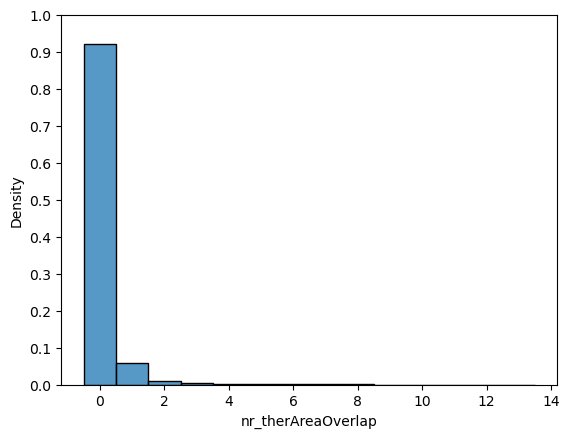

In [43]:
## therapy areas
ax1=sns.histplot(
    data=coloc_indStudy.select("nr_therAreaOverlap").toPandas(),
    x="nr_therAreaOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
    
)
ax1.set_yticks(np.linspace(0, 1, 11))


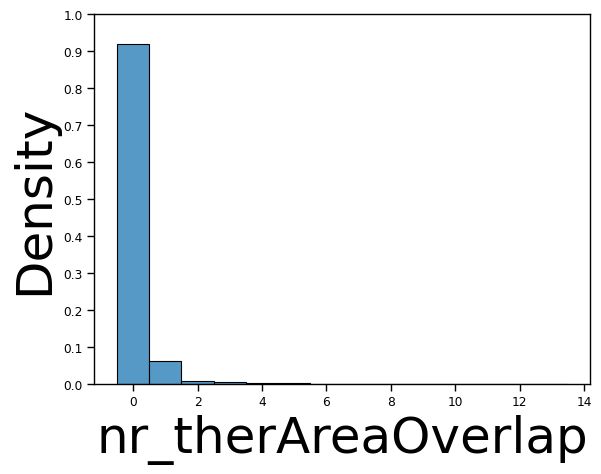

In [113]:
## therapy areas
ax1=sns.histplot(
    data=coloc_indStudy2.select("nr_therAreaOverlap").toPandas(),
    x="nr_therAreaOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
    
)
ax1.set_yticks(np.linspace(0, 1, 11))

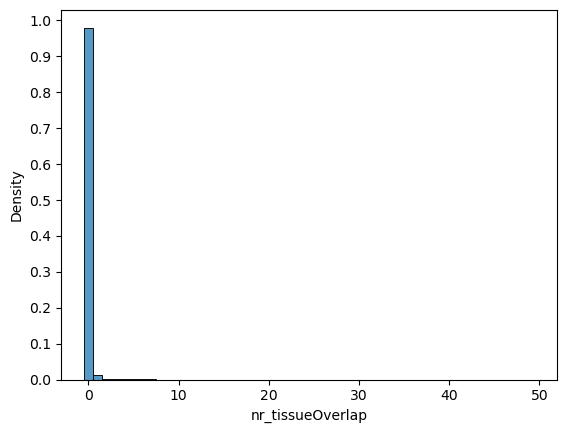

In [47]:
## tissues
ax1=sns.histplot(
    data=coloc_indStudy.select("nr_tissueOverlap").toPandas(),
    x="nr_tissueOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
)
ax1.set_yticks(np.linspace(0, 1, 11))

In [140]:
coloc3.groupBy("left_locus_id").agg(F.countDistinct("left_study_id")).show()

+--------------------+--------------------+
|       left_locus_id|count(left_study_id)|
+--------------------+--------------------+
|     14_77495266_G_C|                   5|
|      8_80377390_G_T|                   1|
|     7_105209290_A_G|                   1|
|     19_44967201_G_C|                   3|
|       7_2833502_C_T|                   1|
|     3_13679430_A_AC|                   1|
|     19_19277248_G_C|                   2|
|     20_62933549_T_G|                  17|
|     2_232925812_T_A|                   5|
|9_133271018_TAAGAC_T|                   4|
|      3_52846724_C_T|                   1|
|     19_57646758_T_C|                   1|
|     19_16346537_T_C|                   1|
|      2_61191208_G_C|                   2|
|     6_108606639_A_G|                  12|
|     1_154432548_A_G|                   2|
|      7_30915924_G_T|                  11|
|      8_10962344_C_T|                   1|
|      11_1867384_C_T|                   6|
|      8_19500923_G_A|          

In [76]:
### number of studies per variant

coloc_study_stats=coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral")).groupBy(
    "left_locus_id",
    "left_study_id",
    "right_gene_id",
    #"right_study_id",
).agg(
    F.countDistinct("right_study_id").alias("nr_studies"),
    F.countDistinct("right_bio_feature").alias("nr_tissues"),
    F.countDistinct("therapyArea").alias("nr_therArea")
).persist()

In [57]:
coloc_study_stats.show()

+--------------------+----------------+---------------+----------+
|       left_locus_id|   left_study_id|  right_gene_id|nr_studies|
+--------------------+----------------+---------------+----------+
|10_100543180_T_TT...|    GCST90000026|ENSG00000166135|         7|
|    10_101931242_G_A|      GCST006979|ENSG00000059915|         1|
|    10_102071841_G_A|     NEALE2_1060|ENSG00000166189|         2|
|    10_102425224_A_G|    GCST90025946|ENSG00000198408|         1|
|   10_102568209_T_TA|     NEALE2_1697|ENSG00000107882|         4|
|    10_102600127_C_T|NEALE2_30080_raw|ENSG00000107872|         2|
|    10_102727686_G_A|    GCST90025974|ENSG00000148842|         4|
|    10_102728114_T_C|NEALE2_23130_raw|ENSG00000138107|        13|
|    10_102832492_A_C|    GCST90012103|ENSG00000138175|         7|
|    10_103046897_A_C|    GCST90002385|ENSG00000138111|         3|
|    10_103095899_T_C|    GCST90025971|ENSG00000214435|         2|
|   10_103148603_CA_C|     NEALE2_1980|ENSG00000148842|       

In [106]:
coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral")).groupBy(
    "left_locus_id",
    #"left_study_id",
    "right_gene_id").count().count()

158746

In [139]:
coloc2.filter(F.col("left_locus_id")=="9_99969955_T_C").sort(F.col("right_study_id").desc()).show(102)


+--------------------+--------------+--------------------+-------------+--------------+---------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+
|   right_bio_feature| left_locus_id|      right_locus_id|left_study_id|right_study_id|  right_gene_id|            coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|
+--------------------+--------------+--------------------+-------------+--------------+---------------+--------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+
|               BLOOD|9_99969955_T_C|    9_99996993_G_GTA| GCST90002304|       TwinsUK|ENSG00000136874|  0.7851363381541818|               -0.0753914|     gwas|      eqtl|     false|          lof| hematologic disease| EFO_0005803|
|                 FAT|9_99969955_T_C|9_100009932_AGGAA...| GCST90002304|    

In [135]:
coloc2.sort(F.col("left_locus_id").desc(),F.col("right_gene_id").desc()).show()

+--------------------+--------------+-------------------+-------------+--------------+---------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+
|   right_bio_feature| left_locus_id|     right_locus_id|left_study_id|right_study_id|  right_gene_id|           coloc_h4|left_var_right_study_beta|left_type|right_type|is_flipped|beta_assessed|         therapyArea|         EFO|
+--------------------+--------------+-------------------+-------------+--------------+---------------+-------------------+-------------------------+---------+----------+----------+-------------+--------------------+------------+
|Brain_Putamen_bas...|9_99969955_T_C|    9_100001301_A_G| GCST90002304|     GTEx-sQTL|ENSG00000241697|0.09587018345681703|      0.14597341418266296|     gwas|      sqtl|      true|          gof|nervous system di...| EFO_0000618|
|Adipose_Subcutaneous|9_99969955_T_C|     9_99527888_C_T| GCST90002304|     GTEx-sQT

In [132]:
coloc_study.sort(F.col("left_locus_id").desc(),F.col("right_gene_id").desc()).show()

+--------------------+----------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+----------+----------+-----------+
|       left_locus_id|   left_study_id|  right_gene_id|         gof_tissues|        gof_therArea|gof_nr_tissues|gof_nr_therArea|gof_count_Studies|         lof_tissues|        lof_therArea|lof_nr_tissues|lof_nr_therArea|lof_count_Studies|     therAreaOverlap|nr_therAreaOverlap|nr_tissueOverlap|nr_studies|nr_tissues|nr_therArea|
+--------------------+----------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+----------+----------+-----------+
|      9_9996

In [77]:
coloc_study=coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral")).groupBy(
    "left_locus_id",
    "left_study_id",
    "right_gene_id",
    #"right_study_id",
).pivot("beta_assessed").agg(
    F.collect_set("right_bio_feature").alias("tissues"),
    F.collect_set("therapyArea").alias("therArea"),
    F.size(F.collect_set("right_bio_feature")).alias("nr_tissues"),
    F.size(F.collect_set("therapyArea")).alias("nr_therArea"),
    F.countDistinct("right_study_id").alias("count_Studies")
).withColumn("therAreaOverlap", F.array_intersect(F.col("gof_therArea"),F.col("lof_therArea"))
).withColumn("nr_therAreaOverlap", F.size(F.array_intersect(F.col("gof_therArea"),F.col("lof_therArea")))
).withColumn("nr_tissueOverlap", F.size(F.array_intersect(F.col("gof_tissues"),F.col("lof_tissues")))
).join(coloc_study_stats,on=[   "left_locus_id","left_study_id","right_gene_id",],how="left"
).persist()

In [110]:
coloc_study2 = (
    coloc3.filter((F.col("count") > 1) & (F.col("beta_assessed") != "neutral"))
    .groupBy(
        "left_locus_id",
        # "left_study_id",
        "right_gene_id",
        # "right_study_id",
    )
    .pivot("beta_assessed")
    .agg(
        F.collect_set("right_bio_feature").alias("tissues"),
        F.collect_set("therapyArea").alias("therArea"),
        F.size(F.collect_set("right_bio_feature")).alias("nr_tissues"),
        F.size(F.collect_set("therapyArea")).alias("nr_therArea"),
        F.countDistinct("right_study_id").alias("count_Studies"),
    )
    .withColumn(
        "therAreaOverlap",
        F.array_intersect(F.col("gof_therArea"), F.col("lof_therArea")),
    )
    .withColumn(
        "nr_therAreaOverlap",
        F.size(F.array_intersect(F.col("gof_therArea"), F.col("lof_therArea"))),
    )
    .withColumn(
        "nr_tissueOverlap",
        F.size(F.array_intersect(F.col("gof_tissues"), F.col("lof_tissues"))),
    )
    .join(
        coloc_study_stats,
        on=[
            "left_locus_id",
            #"left_study_id",
            "right_gene_id",
        ],
        how="left",
    )
    .persist()
)

In [ ]:
### do on the space 

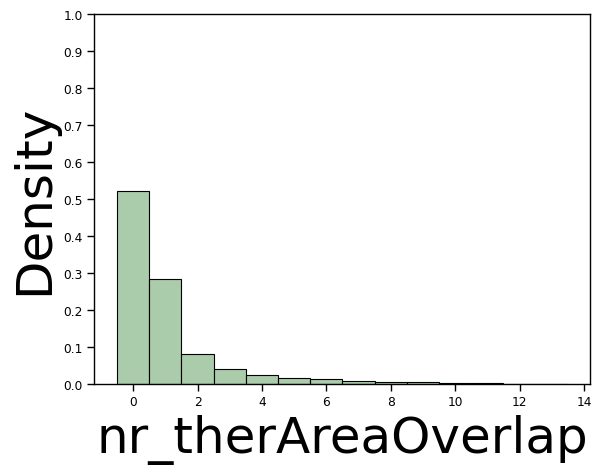

In [111]:
### thearapy areas grouping variants
import seaborn as sns
ax1=sns.histplot(
    data=coloc_study2.select("nr_therAreaOverlap").toPandas(),
    x="nr_therAreaOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
    color='darkseagreen'
)
ax1.set_yticks(np.linspace(0, 1, 11))


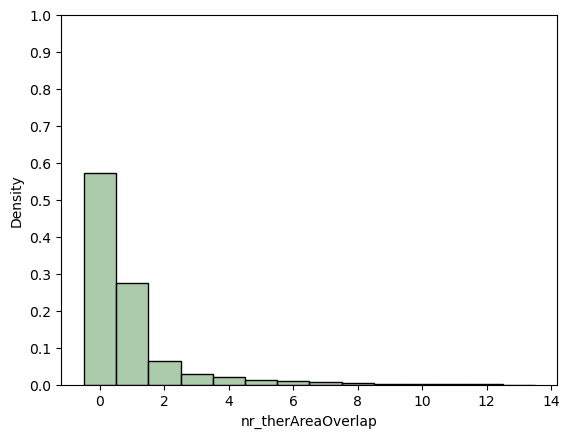

In [51]:
### therapy areas grouping variants

import seaborn as sns

ax1=sns.histplot(
    data=coloc_study.select("nr_therAreaOverlap").toPandas(),
    x="nr_therAreaOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
    color='darkseagreen'
    
)
ax1.set_yticks(np.linspace(0, 1, 11))

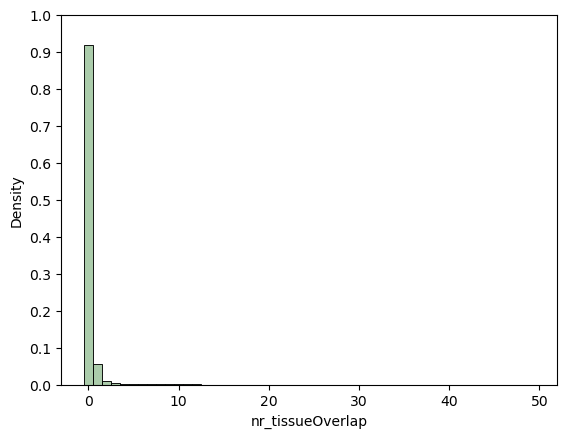

In [52]:
## tissues grouping variants
ax1=sns.histplot(
    data=coloc_study.select("nr_tissueOverlap").toPandas(),
    x="nr_tissueOverlap",
    binwidth=1,
    discrete=True,
    stat="density",
    color='darkseagreen'
)
ax1.set_yticks(np.linspace(0, 1, 11))

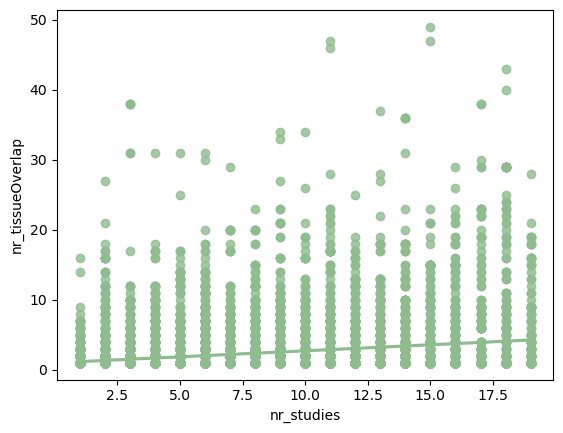

In [97]:
### nr of studies and tissue overlap 
ax1=sns.regplot(
    data=coloc_study.filter((F.col("nr_tissueOverlap")>0) & (F.col("nr_studies") <20)).select("nr_tissueOverlap","nr_studies").toPandas(),
    x="nr_studies",
    y="nr_tissueOverlap",
    #binwidth=1,
    #discrete=True,
    #stat="density",
    color='darkseagreen'
)

In [102]:
coloc_study.count()

259827

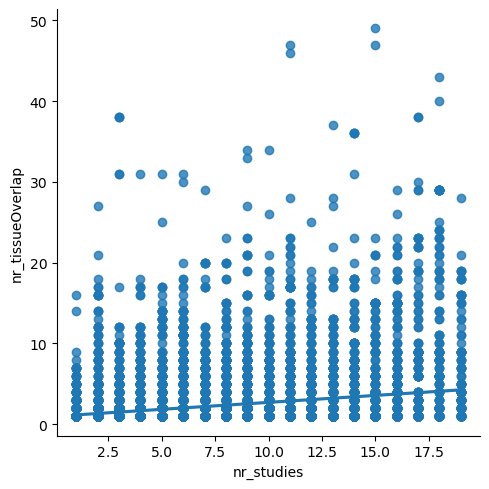

In [80]:
### nr of studies and tissue overlap 
ax1=sns.lmplot(
    data=coloc_study.filter((F.col("nr_tissueOverlap")>0) & (F.col("nr_studies") <20)).select("nr_tissueOverlap","nr_studies").toPandas(),
    x="nr_studies",
    y="nr_tissueOverlap",
    #binwidth=1,
    #discrete=True,
    #stat="density",
    #col='darkseagreen'
)

/opt/conda/miniconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


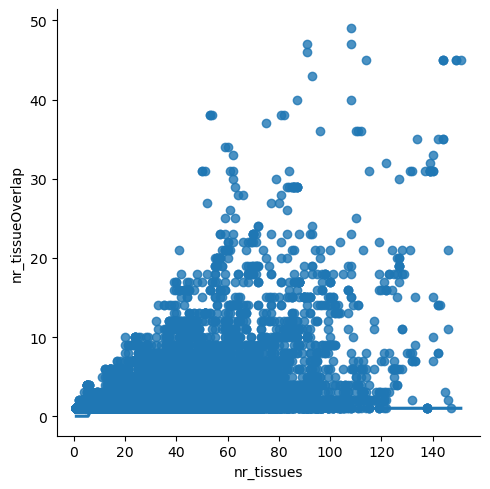

In [91]:
### nr of studies and tissue overlap 
ax1=sns.lmplot(
    data=coloc_study.filter(F.col("nr_tissueOverlap")>0).select("nr_tissueOverlap","nr_tissues").toPandas(),
    x="nr_tissues",
    y="nr_tissueOverlap",
    #binwidth=1,
    #discrete=True,
    #stat="density",
    #col='darkseagreen'
)

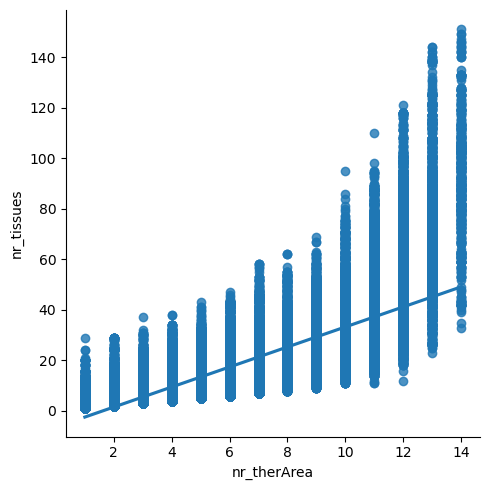

In [93]:
### nr of tissues and nr therapy areas
ax1=sns.lmplot(
    data=coloc_study.select("nr_therArea","nr_tissues").toPandas(),
    x="nr_therArea",
    y="nr_tissues",
    #binwidth=1,
    #discrete=True,
    #stat="density",
    #col='darkseagreen'
)

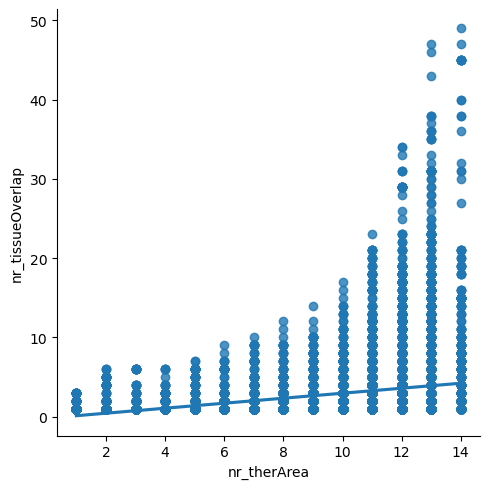

In [95]:
### nr of tissues overlapped and nr therapy areas
ax1=sns.lmplot(
    data=coloc_study.filter(F.col("nr_tissueOverlap")>0).select("nr_therArea","nr_tissueOverlap").toPandas(),
    x="nr_therArea",
    y="nr_tissueOverlap",
    #binwidth=1,
    #discrete=True,
    #stat="density",
    #col='darkseagreen'
)

In [ ]:
#### ver como afecta el coger el mayor beta en valor absoluto

In [82]:
coloc_study.filter((F.col("nr_tissueOverlap")>0)).show()


+-----------------+--------------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+----------+----------+-----------+
|    left_locus_id|       left_study_id|  right_gene_id|         gof_tissues|        gof_therArea|gof_nr_tissues|gof_nr_therArea|gof_count_Studies|         lof_tissues|        lof_therArea|lof_nr_tissues|lof_nr_therArea|lof_count_Studies|     therAreaOverlap|nr_therAreaOverlap|nr_tissueOverlap|nr_studies|nr_tissues|nr_therArea|
+-----------------+--------------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+----------+----------+-----------+
| 10_10309

In [101]:
### pair plot only for contradictions
sns.pairplot(coloc_study.filter((F.col("nr_tissueOverlap")>0)).toPandas(),size=20)


/opt/conda/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


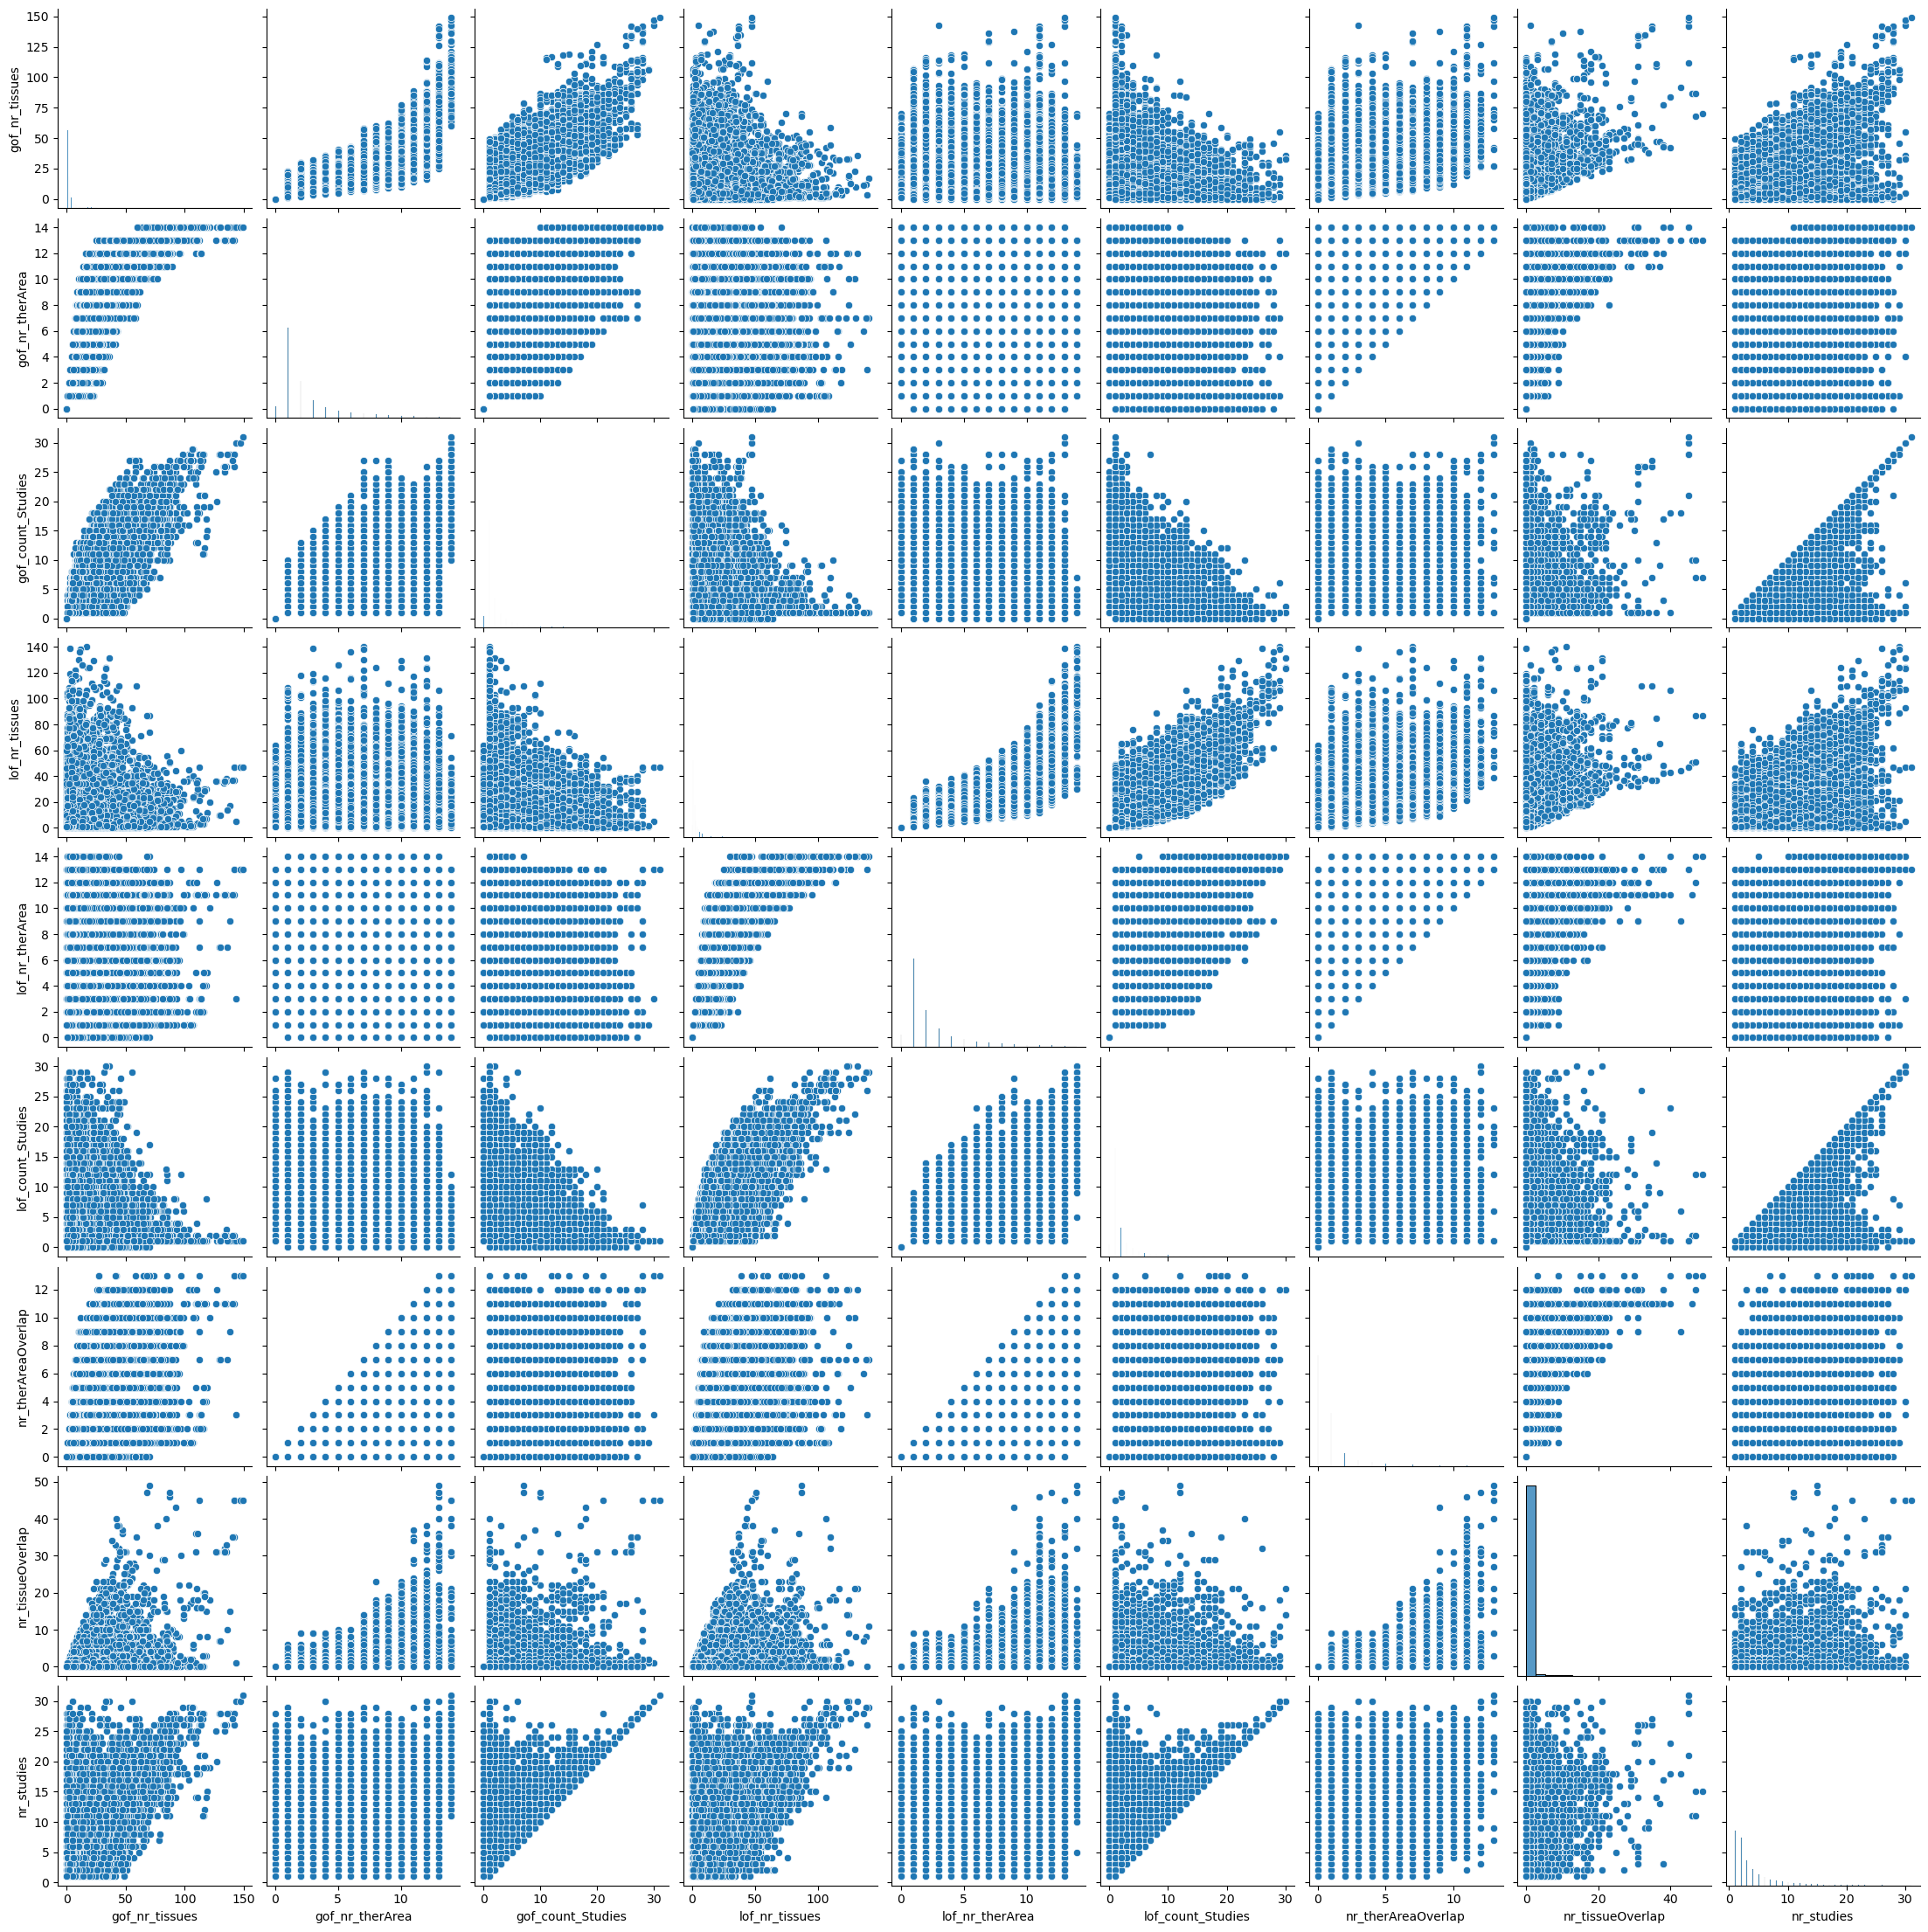

In [66]:
sns.pairplot(coloc_study.toPandas())

In [11]:
coloc_study.show()

+--------------------+----------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+
|       left_locus_id|   left_study_id|  right_gene_id|         gof_tissues|        gof_therArea|gof_nr_tissues|gof_nr_therArea|gof_count_Studies|         lof_tissues|        lof_therArea|lof_nr_tissues|lof_nr_therArea|lof_count_Studies|     therAreaOverlap|nr_therAreaOverlap|nr_tissueOverlap|
+--------------------+----------------+---------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+--------------------+--------------+---------------+-----------------+--------------------+------------------+----------------+
|10_100543180_T_TT...|    GCST90000026|ENSG00000166135|      [MUSCLE_NAIVE]|[musculoskeletal ...|             1|   

In [26]:
coloc_study.groupBy("nr_therAreaOverlap").count().show()

+------------------+------+
|nr_therAreaOverlap| count|
+------------------+------+
|                12|    81|
|                 1| 71626|
|                 6|  2246|
|                 3|  7598|
|                 5|  3031|
|                 9|   738|
|                 4|  5228|
|                 8|  1148|
|                 7|  1700|
|                10|   453|
|                11|   314|
|                 2| 16867|
|                 0|148777|
|                13|    20|
+------------------+------+



In [31]:
coloc_study.groupBy("nr_tissueOverlap").count().show()

+----------------+------+
|nr_tissueOverlap| count|
+----------------+------+
|               1| 14452|
|               6|   357|
|               3|  1230|
|               5|   411|
|               9|   160|
|               4|   686|
|               8|   185|
|               7|   278|
|              10|   105|
|               2|  2587|
|               0|238771|
|              17|    40|
|              11|    78|
|              18|    39|
|              14|    50|
|              12|    84|
|              15|    49|
|              40|     2|
|              45|     7|
|              31|    17|
+----------------+------+
only showing top 20 rows



In [12]:
coloc3.select("right_study_id").distinct().count()

38

In [97]:
coloc3.select("right_bio_feature").distinct().toPandas().to_csv("tissues_coloc.csv")

In [68]:
print((243220+16607)/666261)

0.389977801492208


In [38]:
coloc3=coloc2.join(v2d_gwas.withColumnRenamed("study_id","left_study_id"), on=["left_locus_id","left_study_id"],how="left").persist()

In [39]:
coloc3.filter(F.col("is_flipped")=="true").show(truncate=False,vertical=True)

-RECORD 0---------------------------------------------
 left_locus_id             | 10_100152307_T_C         
 left_study_id             | GCST90025955             
 right_locus_id            | 10_100129660_T_C         
 right_study_id            | GTEx-sQTL                
 right_gene_id             | ENSG00000155287          
 coloc_h4                  | 0.9678297263356717       
 left_var_right_study_beta | -0.4308566451072693      
 left_type                 | gwas                     
 right_type                | sqtl                     
 right_bio_feature         | Brain_Cortex             
 is_flipped                | true                     
 beta                      | 0.0280807                
 odds_ratio                | null                     
 trait_reported            | Apolipoprotein A1 levels 
 trait_efos                | [EFO_0004614]            
 n_cases                   | null                     
 n_initial                 | 398508                   
-RECORD 1-

In [46]:
coloc3.groupBy("left_locus_id","right_locus_id","left_study_id").agg(F.countDistinct("right_gene_id").alias("count")).sort(F.col("count").desc()).show()

23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_27 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_7 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_95 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_121 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_197 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_91 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_81 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_160 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_116 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_155_54 !
23/09/14 10:43:09 WARN BlockManagerMasterEndpoi

KeyboardInterrupt: 